In [169]:
import numpy as np
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
# %matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt
# print(plt.style.available)  # show available template
plt.style.use(['seaborn-ticks','seaborn-paper'])  # use a templet

import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['lines.color'] = 'r'
params = {
    'figure.figsize': [8, 6], # Note! figure unit is inch!  scale fontz size 2.54 to looks like unit cm
    'axes.labelsize': 7*2.54, # scale 2.54 to change to figure unit looks as cm
    'font.size':  7*2.54,
    'lines.linewidth':2,
    'axes.linewidth': 1.0,  # default 1.25
    'legend.fontsize': 7*2.54,
    'xtick.labelsize': 6*2.54,
    'ytick.labelsize': 6*2.54,
    'text.usetex': False,  
    'xtick.direction': "in",
    'ytick.direction': "in", # ticket inside
    'legend.frameon' : True, 
    'legend.edgecolor': 'black',
    'legend.shadow': True,
    'legend.framealpha':1,
#     'patch.linewidth' : 0.5, 
}
mpl.rcParams.update(params)
from qutip import *
import itertools

In [182]:
def GenOmega(laserPolarization, s):
    # laserPolarization:  (pi, sigma_plus, sigma_minus) compoment
    # s saturation parameter
    
    linewidth = 19.7 * 1e6  # Hz
    pi, sigma_plus, sigma_minus = laserPolarization
    _omega = 2 * np.pi *linewidth * np.sqrt(s)

    omega = np.zeros((8, 8))
    omega[0][7] = omega[7][0] = \
    omega[1][4] = omega[4][1] = \
    omega[1][6] = omega[6][1] = \
    omega[2][7] = omega[7][2] = _omega * sigma_plus

    omega[0][5] = omega[5][0] = \
    omega[2][5] = omega[5][2] = \
    omega[3][4] = omega[4][3] = \
    omega[3][6] = omega[6][3] = _omega * sigma_minus

    omega[0][6] = omega[6][0] = \
    omega[1][5] = omega[5][1] = \
    omega[2][4] = omega[4][2] = \
    omega[3][7] = omega[7][3] = _omega * pi
    
    return omega


def Hamiltonian(tau, s, Delta, delta, B, sign):
    # tau; time of chirp
    # s ：saturation parameter
    # detuning： \Delta   GHz
    # delta：    \delta   GHz
    
    # spontanouse decay rate
    linewidth = 19.7 * 1e6  # Hz
    
    # hyperfine splitting
    s_splitting = 12642.812118466  # MHz
    p_splitting = 2105  # MHz
    quadratic_shift = 310.8  # B**2 Hz (B in Gauss)
    
    mF = np.zeros(8)
    mF[1] = -1
    mF[3] = 1
    mF[5] = -1
    mF[7] = 1
    
    cg = np.zeros((8, 8))
    # pi transitions
    cg[0][6] = cg[6][0] = 1 / np.sqrt(3)
    cg[1][5] = cg[5][1] = -1 / np.sqrt(3)
    cg[2][4] = cg[4][2] = 1 / np.sqrt(3)
    cg[3][7] = cg[7][3] = 1 / np.sqrt(3)

    # sigma+ transitions
    cg[0][7] = cg[7][0] = -1 / np.sqrt(3)
    cg[1][4] = cg[4][1] = 1 / np.sqrt(3)
    cg[1][6] = cg[6][1] = 1 / np.sqrt(3)
    cg[2][7] = cg[7][2] = 1 / np.sqrt(3)

    # sigma- transitions
    cg[0][5] = cg[5][0] = -1 / np.sqrt(3)
    cg[2][5] = cg[5][2] = -1 / np.sqrt(3)
    cg[3][4] = cg[4][3] = 1 / np.sqrt(3)
    cg[3][6] = cg[6][3] = -1 / np.sqrt(3)
    
    alpha = (Delta-12.642)/(Delta+12.642)
#     alpha_p = np.sqrt(np.sqrt(((alpha**2 -1)**2 /2)**2 + alpha**2) + (alpha**2 -1)**2 /2)
#     alpha_s = np.sqrt(np.sqrt(((alpha**2 -1)**2 /2)**2 + alpha**2) - (alpha**2 -1)**2 /2)
#     sat_x= s*alpha_p
#     sat_y= s*alpha_s/alpha
    
    sat_x= s
    sat_y= s/alpha    
    
    def delta_coeff(t, args):  #双光子失谐
        return 2*np.pi*delta*1e9*np.cos(np.pi*t/tau)

    def sat_coeff(t, args):   #波形
#         if (int(t/tau) % 2 ) == 0:
#             return np.sin(np.pi*t/tau)
#         else:
#             return np.sin(np.pi*(t-tau)/tau)
        return np.sin(np.pi*t/tau)
    
    # X line porlar light : sigma_+ + sigma_-
    Polarization_x = (0, 1/np.sqrt(2), 1/np.sqrt(2))
    Polarization_y = (0, -1/np.sqrt(2), 1/np.sqrt(2))
    
    omega = GenOmega(Polarization_x, sat_x)

    off_diagonal_elements = 0
    for i, j in itertools.product(range(8),range(8)):
        off_diagonal_elements += omega[i][j] / 2 * cg[i][j]**2 * basis(8,i) * basis(8,j).dag()

    # Y line porlar light : sigma_+ - sigma_-
    #     Polarization_y = (0, 1/np.sqrt(2), -1/np.sqrt(2))
    omega = GenOmega(Polarization_y, sat_y)
    #     omega = GenOmega(Polarization_y, sat_x)
    for i, j in itertools.product(range(8),range(8)):
        off_diagonal_elements += omega[i][j] / 2 * cg[i][j] ** 2 * basis(8,i) * basis(8,j).dag()

    ee = np.sum(basis(8,i) * basis(8,i).dag() for i in (4, 5, 6, 7))
    g1 = np.sum(basis(8,i) * basis(8,i).dag() for i in (1,2,3))
    g0 = basis(8,0) * basis(8,0).dag()
    
    ee_shifts = 2 * np.pi*0.47e6*B*(mF[5]* basis(8,5) * basis(8,5).dag()+\
                                      mF[7]* basis(8,7) * basis(8,7).dag())- 2*np.pi*p_splitting*1e6*basis(8,4) * basis(8,4).dag()
    g1_shifts = 2 * np.pi*1.4e6*B*(mF[1]* basis(8,1) * basis(8,1).dag()+\
                                      mF[3]* basis(8,3) * basis(8,3).dag())
    g0_shifts = 2 * np.pi * quadratic_shift * B ** 2* basis(8,0) * basis(8,0).dag()

    
    diagonal_elements= 2*np.pi*Delta*1e9*(ee-g1) + 2*np.pi*Delta*1e9*(ee-g0) + (ee_shifts-g1_shifts) + (ee_shifts-g0_shifts)
    diagonal_elements/=2.0
    

    c_ops = []
    for i in range(4):
        c_ops.append (np.sqrt(2 * np.pi * linewidth) * cg[i][4]* basis(8,i) * basis(8,4).dag())
    for i in range(4):
        c_ops.append (np.sqrt(2 * np.pi * linewidth) * cg[i][5]* basis(8,i) * basis(8,5).dag())
    for i in range(4):
        c_ops.append (np.sqrt(2 * np.pi * linewidth) * cg[i][6]* basis(8,i) * basis(8,6).dag())
    for i in range(4):
        c_ops.append (np.sqrt(2 * np.pi * linewidth) * cg[i][7]* basis(8,i) * basis(8,7).dag())
        
    
    H = [diagonal_elements,[(-ee+g0)/2.0,delta_coeff],[off_diagonal_elements,sat_coeff]]
    
    if sign == 0:
        H = [diagonal_elements,[(-ee+g0)/2.0,delta_coeff],[off_diagonal_elements,sat_coeff]]
    else:
        omega = GenOmega(Polarization_x, sat_y)

        off_diagonal_elements = 0
        for i, j in itertools.product(range(8),range(8)):
            off_diagonal_elements = omega[i][j] / 2 * cg[i][j]**2 * basis(8,i) * basis(8,j).dag()

        # Y line porlar light : sigma_+ - sigma_-
        #     Polarization_y = (0, 1/np.sqrt(2), -1/np.sqrt(2))
        omega = GenOmega(Polarization_y, sat_x)
        #     omega = GenOmega(Polarization_y, sat_x)
        for i, j in itertools.product(range(8),range(8)):
            off_diagonal_elements = omega[i][j] / 2 * cg[i][j] ** 2 * basis(8,i) * basis(8,j).dag()
        H = [-diagonal_elements,[(-ee+g0)/2.0,delta_coeff],[off_diagonal_elements,sat_coeff]]
    return (H, c_ops)

In [3]:
psi0=basis(8,0) #initial state
population = basis(8,2)*basis(8,2).dag()
H, c_ops = Hamiltonian(0.2e-9,20e6,121.5,7.05,10,0)
t = np.linspace(0, 0.2e-9, 500)
output = mesolve(H, psi0, t, c_ops, population)
t1 = np.linspace(0, 2e-9, 500) 
output2 = mesolve(H, psi0, t1, c_ops, population)

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


In [4]:
psi1 = basis(8,2) #initial state
population1 = basis(8,2)*basis(8,2).dag()
H, c_ops = Hamiltonian(0.2e-9,20e6,121.5,7.05,10,0)
t = np.linspace(0, 0.2e-9, 500)
output1 = mesolve(H, psi1, t, c_ops, population)
t1 = np.linspace(0, 2e-9, 500) 
output3 = mesolve(H, psi1, t1, c_ops, population)

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


Text(0.5, 0, 'time (ns)')

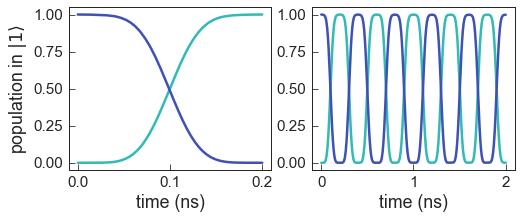

In [5]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(t*1e9,output.expect[0], linewidth=2.5 ,c='#32bab5')
plt.plot(t*1e9,output1.expect[0], linewidth=2.5 ,c='#3F51B5')
plt.ylabel('population in '+r'$|1\rangle$')
plt.xlabel(r"time (ns)")
plt.subplot(1,2,2)
plt.plot(t1*1e9,output2.expect[0], linewidth=2.5 ,c='#32bab5')
plt.plot(t1*1e9,output3.expect[0], linewidth=2.5 ,c='#3F51B5')
# plt.ylabel('population in '+r'$|1\rangle$')
plt.xlabel(r"time (ns)")

In [6]:
rx = basis(8, 0) * basis(8, 2).dag() + basis(8, 2) * basis(8, 0).dag()
ry = 1j * (basis(8, 0) * basis(8, 2).dag() - basis(8, 2) * basis(8, 0).dag())
rz = basis(8, 0) * basis(8, 0).dag() - basis(8, 2) * basis(8, 2).dag()
H, c_ops = Hamiltonian(0.2e-9,20e6,121.5,7.05,10,0)
t = np.linspace(0e-9, 1e-9, 500)
bloch_vectors = mesolve(H, psi0, t, c_ops, [rx, ry, rz])

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  func(*args, **kwargs)


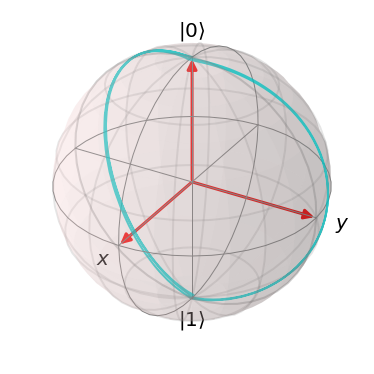

In [7]:
b = Bloch()
vec = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
b.add_vectors(vec)
b.add_points([bloch_vectors.expect[0], bloch_vectors.expect[1], bloch_vectors.expect[2]], meth='l')
b.vector_color = 'r'
b.point_color = 'CC6600'
b.size = [3,3]
b.show()
# plt.savefig('../fig/bloch_4.pdf')

In [183]:
psi0 = basis(8,0)
psi1 = basis(8,2)
x = []
y = []
z = []
rx = basis(8, 0) * basis(8, 2).dag() + basis(8, 2) * basis(8, 0).dag()
ry = 1j * (basis(8, 0) * basis(8, 2).dag() - basis(8, 2) * basis(8, 0).dag())
rz = basis(8, 0) * basis(8, 0).dag() - basis(8, 2) * basis(8, 2).dag()
init_state = psi0
p = np.zeros(10)
P = np.zeros(10)
population = basis(8,2)*basis(8,2).dag()
for i in range(10):
    t_i = 0.4*i
    t_f = t_i + 0.2
    t = np.linspace(t_i*1e-9, t_f*1e-9, 500)
    H, c_ops = Hamiltonian(0.2e-9,20e6,121.5,7.05,10,0)
    bloch_vectors = mesolve(H, init_state, t, c_ops, [rx, ry, rz, population])
    x.append(list(bloch_vectors.expect[0]))
    y.append(list(bloch_vectors.expect[1]))
    z.append(list(bloch_vectors.expect[2]))
    p[i] = 1-bloch_vectors.expect[3][-1]
#     print(T_i, T_f, bloch_vectors[0][-1], bloch_vectors[1][-1], bloch_vectors[2][-1])
    init_state = mesolve(H, init_state, t, c_ops, []).states[-1]
    T_i = t_f
    T_f = T_i + 0.2
    t = np.linspace(T_i*1e-9, T_f*1e-9, 500)
    H, c_ops = Hamiltonian(0.2e-9,20e6,121.5,7.05,10,1)
    bloch_vectors = mesolve(H, init_state, t, c_ops, [rx, ry, rz, population])
    x.append(list(bloch_vectors.expect[0]))
    y.append(list(bloch_vectors.expect[1]))
    z.append(list(bloch_vectors.expect[2]))
    init_state = mesolve(H, init_state, t, c_ops, []).states[-1]
    P[i] = bloch_vectors.expect[3][-1]
#     print(T_i, T_f, bloch_vectors[0][-1], bloch_vectors[1][-1], bloch_vectors[2][-1])


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


In [184]:
psi0=basis(8,0) #initial state
population = basis(8,2)*basis(8,2).dag()
H, c_ops = Hamiltonian(0.2e-9,20e6,121.5,7.05,10,0)
t = np.linspace(0, 4e-9, 5000)
output = mesolve(H, psi0, t, c_ops, population)
p1 = np.zeros(10)
P1 = np.zeros(10)
for i in range(10):
    p1[i] = 1-output.expect[0][250*(2*i+1)-1]
    P1[i] = output.expect[0][250*(2*i+2)-1]

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


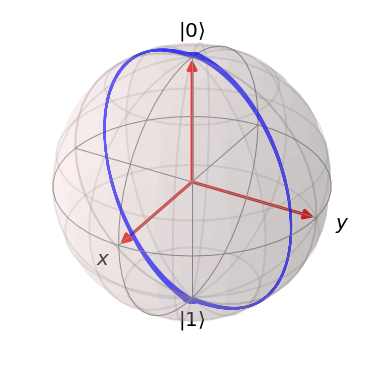

In [185]:
b = Bloch()
vec = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
b.add_vectors(vec)
# b.add_points([bloch_vectors.expect[0], bloch_vectors.expect[1], bloch_vectors.expect[2]], meth='l')
# b.add_points([list(_flatten(x)), list(_flatten(y)), list(_flatten(z))], meth='l')
b.add_points([np.array(x).flatten(), np.array(y).flatten(), np.array(z).flatten()], meth='l')
b.vector_color = 'r'
b.size = [3,3]
b.show()
# plt.savefig('../fig/bloch1.pdf')

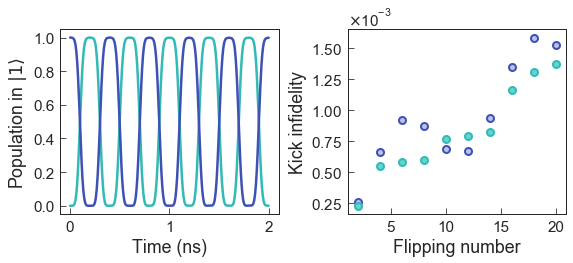

In [91]:
fig1, axs = plt.subplots(1, 2,figsize=(8.3,4))
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)

axs[0].plot(t1*1e9,output2.expect[0], linewidth=2.5 ,c='#32bab5')
axs[0].plot(t1*1e9,output3.expect[0], linewidth=2.5 ,c='#3F51B5')
axs[0].set_ylabel('Population in '+r'$|1\rangle$')
axs[0].set_xlabel(r"Time (ns)")

axs[1].plot(range(2,21,2), P, 'o',ms=7,markeredgewidth=2, markeredgecolor='#3F51B5', markerfacecolor='#BBC2E7')
axs[1].plot(range(2,21,2), np.sort(P1), 'o',ms=7,markeredgewidth=2, markeredgecolor='#32bab5', markerfacecolor='#63d5d1')
axs[1].set_xlabel('Flipping number')
axs[1].set_ylabel('Kick infidelity')
axs[1].ticklabel_format(axis='y',style='sci',scilimits=(0,3),useMathText=True)
plt.tight_layout()
# plt.savefig('../fig/fiedlity_3_part.pdf')

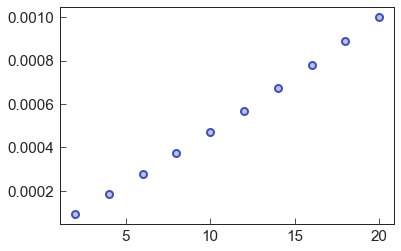

In [4]:
plt.plot(range(2,21,2), P, 'o',ms=7,markeredgewidth=2, markeredgecolor='#3F51B5', markerfacecolor='#BBC2E7')

In [12]:
0.001/10/5

2e-05

In [187]:
53600-35000

18600